# Analyse des ventes du site web

Faire le point après deux ans d’exercice du site, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

Il y a 3 fichiers csv qui sont mis à disposition :

- customers.csv : un fichier qui contient l'identifiant du client, son sexe et l'année de naissance.
- products.csv : un fichier qui contient la référence produit, son prix et la catégorie.
- transactions.csv : un fichier qui concerne les transactions du site. Il fait le lien entre  le fichier customers et products. Il contient l'identifiant du client et la référence du produit ainsi que la date de la transaction et son identifiant.

## Table des matières

* [Import des librairies et des données](#import)
* [Observation des Dataframes](#dataframe)
* [Rapprochement des exports client et produit](#merge)
* [Analyse des ventes](#analyse_ventes)
    - [Chiffre d'affaires](#CA)
        - [Répartition du chiffre d'affaires par catégorie](#catégorie)
        - [Répartition du chiffre d'affaire par tranche d'âge](#tranche_age)
        - [Répartition du chiffre d'affaires par catégorie dans le temps](#catégorie_temps)
        - [Moyenne mobile](#moyenne_mobile)
    - [Zoom sur les références](#référence)
        - [Meilleures et moins bonnes ventes](#top_flop_global)
        - [Meilleures et moins bonnes ventes par catégorie](#top_flop_catégorie)
    - [Courbe de Lorenz](#lorenz)
* [Analyse de la clientèle](#analyse_client)

## Import des librairies et des données : <a name="import"></a>

In [2]:
import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

clients = pd.read_csv("C:/Users/Greg/Documents/entreprise/data/Openclassroom/Projet 6 Analysez les ventes d'une librairie avec R ou Python/DAN-P6-donnees/customers.csv")
produits = pd.read_csv("C:/Users/Greg/Documents/entreprise/data/Openclassroom/Projet 6 Analysez les ventes d'une librairie avec R ou Python/DAN-P6-donnees/products.csv")
transactions = pd.read_csv("C:/Users/Greg/Documents/entreprise/data/Openclassroom/Projet 6 Analysez les ventes d'une librairie avec R ou Python/DAN-P6-donnees/transactions.csv")


## Observation des Dataframes : <a name="dataframe"></a>

**Dataframe client**  

La clé primaire est la colonne client_id, on va vérifier si il n'y a pas d'erreur avec cette dernière.

In [2]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


Il y a aucune valeur nulle pour la colonne client_id, on a bien au total 8623 lignes.

In [3]:
clients.loc[clients['client_id'].duplicated(keep=False),:]

,client_id,sex,birth


La colonne client_id n'a pas de valeur en double.  
La clé primaire n'a aucune erreur, on va voir les informations contenues dans le dataframe.

In [4]:
clients.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


Pas de problème sur les années de naissance avec l'année la plus éloignée à 1929 et 2004 pour l'année la plus proche.

In [5]:
clients

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


L'année de naissance va être remplacée par l'age qui va être une donnée plus utile dans notre analyse.  
La colonne client_id est composée de la manière suivente : "c_" devant des chiffres.   

In [6]:
clients.sort_values('client_id', ascending = False)

,client_id,sex,birth
8494,ct_1,m,2001
2735,ct_0,f,2001
7358,c_999,m,1964
2145,c_998,m,2001
94,c_997,f,1994
...,...,...,...
3426,c_1001,m,1982
8472,c_1000,f,1966
2137,c_100,m,1992
6894,c_10,m,1956


In [7]:
clients.loc[clients['client_id'] > 'ct_', :]

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


2 lignes ont pour préfixe "ct_" au lieu de "c_", on faudra voir au moment du rapprochement à quoi correspondent ces valeurs.

In [3]:
# Récupération de la date actuelle
maDate = datetime.date.today()

# Renomme la colonne birth en colonne age
clients = clients.rename(columns={'birth': 'age'})

# Calcul de l'age des clients
clients['age'] = maDate.year - clients['age']

clients

,client_id,sex,age
0,c_4410,f,56
1,c_7839,f,48
2,c_1699,f,39
3,c_5961,f,61
4,c_5320,m,80
...,...,...,...
8618,c_7920,m,67
8619,c_7403,f,53
8620,c_5119,m,49
8621,c_5643,f,55


Pour la colonne sex, on va vérifier, s'il n'y a pas d'erreur de saisie.

In [9]:
clients['sex'].unique()

array(['f', 'm'], dtype=object)

Aucune présence d'erreur.  

**Dataframe produit**

In [10]:
produits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


La clé primaire id_prod n'a pas de valeur nulle, on a bien 3287 lignes.

In [11]:
produits.loc[produits['id_prod'].duplicated(keep=False),:]

,id_prod,price,categ


Aucun doublon pour la colonne id_prod.

In [12]:
produits.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


Il y a un problème au niveau des prix, le montant minimum est de -1. Ces lignes devront être supprimées après le rapprochement des dataframe.

In [13]:
produits.loc[produits['price'] < 0,:]

,id_prod,price,categ
731,T_0,-1.0,0


Une ligne est concernée par le prix négatif.

In [14]:
produits

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


Les valeurs de la colonne id_prod sont composées de la manière où le préfixe correspond à la catégorie (0_ pour 0, 1_ pour 1, etc).  
On vérifie qu'il n'y a pas d'erreur dans la colonne id_prod.

In [15]:
produits.sort_values('id_prod', ascending = False)

,id_prod,price,categ
731,T_0,-1.00,0
3188,2_99,84.99,2
3088,2_98,149.74,2
2698,2_97,160.99,2
2576,2_96,47.91,2
...,...,...,...
922,0_1000,6.84,0
663,0_100,20.60,0
2691,0_10,17.95,0
803,0_1,10.99,0


In [17]:
produits.loc[produits['id_prod'] > 'T_', :]

,id_prod,price,categ
731,T_0,-1.0,0


La valeur différente dans la colonne id_prod correspond au prix négatif.  
On vérifie les différentes catégories.

In [18]:
produits['categ'].unique()

array([0, 1, 2], dtype=int64)

Il y a 3 catégories différentes pour les produits.  

**Dataframe transaction**

Le dataframe transaction va servir de lien entre client et produit grâce aux colonnes id_prod et client_id.

In [19]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


Il y a aucune valeur nulle pour les colonnes id_prod et client_id sur l'ensemble des lignes, la jointure peut être faite.  
Il faudra changer le type de la colonne date en datetime.

In [20]:
transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


La colonne date présente un problème, il y a le mot "test_" juste avant l'affichage de la date, on va voir si plusieurs lignes sont concernées.

In [21]:
transactions.loc[transactions['date'] > 'test_',:]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


200 lignes sont concernées, il faudra les supprimer. De plus, il y a des valeurs tests pour les autres colonnes qui correspondent aux autres valeurs tests dans les autres dataframe.  
La valeur de session_id pour ces valeurs tests est s_0, T_0 et ct_0. 

In [22]:
transactions

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


Aucune autre erreur détecter.

## Rapprochement des exports client et produit <a name="merge"></a>

In [4]:
# On merge (right) de client et transaction dans un dataframe intermediaire.
intermediaire = clients.merge(transactions, on='client_id', how='right')

intermediaire

,client_id,sex,age,id_prod,date,session_id
0,c_103,f,37,0_1518,2022-05-20 13:21:29.043970,s_211425
1,c_8534,m,35,1_251,2022-02-02 07:55:19.149409,s_158752
2,c_6714,f,55,0_1277,2022-06-18 15:44:33.155329,s_225667
3,c_6941,m,23,2_209,2021-06-24 04:19:29.835891,s_52962
4,c_4232,m,43,0_1509,2023-01-11 08:22:08.194479,s_325227
...,...,...,...,...,...,...
679527,c_8489,f,72,0_1551,2022-01-15 13:05:06.246925,s_150195
679528,c_4370,f,46,1_639,2022-03-19 16:03:23.429229,s_181434
679529,c_304,f,35,0_1425,2022-12-20 04:33:37.584749,s_314704
679530,c_2227,m,37,0_1994,2021-07-16 20:36:35.350579,s_63204


Pas de problème au niveau du merge, on a bien les 679 532 lignes.

In [5]:
# On merge (left) notre dataframe intermediaire avec produit
ventes = intermediaire.merge(produits, on='id_prod', how='left')

ventes

,client_id,sex,age,id_prod,date,session_id,price,categ
0,c_103,f,37,0_1518,2022-05-20 13:21:29.043970,s_211425,4.18,0.0
1,c_8534,m,35,1_251,2022-02-02 07:55:19.149409,s_158752,15.99,1.0
2,c_6714,f,55,0_1277,2022-06-18 15:44:33.155329,s_225667,7.99,0.0
3,c_6941,m,23,2_209,2021-06-24 04:19:29.835891,s_52962,69.99,2.0
4,c_4232,m,43,0_1509,2023-01-11 08:22:08.194479,s_325227,4.99,0.0
...,...,...,...,...,...,...,...,...
679527,c_8489,f,72,0_1551,2022-01-15 13:05:06.246925,s_150195,12.99,0.0
679528,c_4370,f,46,1_639,2022-03-19 16:03:23.429229,s_181434,10.99,1.0
679529,c_304,f,35,0_1425,2022-12-20 04:33:37.584749,s_314704,12.99,0.0
679530,c_2227,m,37,0_1994,2021-07-16 20:36:35.350579,s_63204,4.98,0.0


Le dataframe ventes à bien les 679 532 lignes. On peut passer à la suppression des valeurs tests.  
Les valeurs sont "ct_" pour client_id, "T_" pour id_prod, "test_" pour la date, "s_0" pour session_id et le prix à -1.

In [6]:
# Ajout des paramétres des valeurs nullles dans une variable.
valeursTest = (ventes['date'] > 'test_') & (ventes['client_id'] > 'ct_') & (ventes['id_prod'] > 'T_') &  (ventes['session_id'] == 's_0') & (ventes['price'] < 0)

ventes.loc[valeursTest  , :]

,client_id,sex,age,id_prod,date,session_id,price,categ
3019,ct_0,f,22,T_0,test_2021-03-01 02:30:02.237419,s_0,-1.0,0.0
5138,ct_0,f,22,T_0,test_2021-03-01 02:30:02.237425,s_0,-1.0,0.0
9668,ct_1,m,22,T_0,test_2021-03-01 02:30:02.237437,s_0,-1.0,0.0
10728,ct_0,f,22,T_0,test_2021-03-01 02:30:02.237436,s_0,-1.0,0.0
15292,ct_0,f,22,T_0,test_2021-03-01 02:30:02.237430,s_0,-1.0,0.0
...,...,...,...,...,...,...,...,...
657830,ct_0,f,22,T_0,test_2021-03-01 02:30:02.237417,s_0,-1.0,0.0
662081,ct_1,m,22,T_0,test_2021-03-01 02:30:02.237427,s_0,-1.0,0.0
670680,ct_1,m,22,T_0,test_2021-03-01 02:30:02.237449,s_0,-1.0,0.0
671647,ct_1,m,22,T_0,test_2021-03-01 02:30:02.237424,s_0,-1.0,0.0


200 lignes sont concernées comme valeur de test. On va passer à la suppression.

In [7]:
ventes = ventes.drop(ventes[valeursTest].index)

ventes.loc[valeursTest  , :]

,client_id,sex,age,id_prod,date,session_id,price,categ


In [27]:
ventes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   client_id   679332 non-null  object 
 1   sex         679332 non-null  object 
 2   age         679332 non-null  int64  
 3   id_prod     679332 non-null  object 
 4   date        679332 non-null  object 
 5   session_id  679332 non-null  object 
 6   price       679111 non-null  float64
 7   categ       679111 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 46.6+ MB


Il reste 679 332 lignes, les 200 lignes on bien été supprimées.  
Les colonnes price et categ présentent des valeurs nulles. 

In [28]:
ventes.isnull().sum()

client_id       0
sex             0
age             0
id_prod         0
date            0
session_id      0
price         221
categ         221
dtype: int64

221 lignes sont des valeurs nulles. On va voir plus en détail les lignes concernées.

In [29]:
ventes.loc[ventes['price'].isnull(), :]

,client_id,sex,age,id_prod,date,session_id,price,categ
2633,c_4746,m,83,0_2245,2022-09-23 07:22:38.636773,s_272266,NaN,NaN
10106,c_6713,f,60,0_2245,2022-07-23 09:24:14.133889,s_242482,NaN,NaN
11727,c_5108,m,45,0_2245,2022-12-03 03:26:35.696673,s_306338,NaN,NaN
15675,c_1391,m,32,0_2245,2021-08-16 11:33:25.481411,s_76493,NaN,NaN
16377,c_7954,m,50,0_2245,2022-07-16 05:53:01.627491,s_239078,NaN,NaN
...,...,...,...,...,...,...,...,...
669730,c_131,m,42,0_2245,2021-08-25 09:06:03.504061,s_80395,NaN,NaN
670682,c_4167,f,44,0_2245,2022-03-06 19:59:19.462288,s_175311,NaN,NaN
671286,c_4453,m,42,0_2245,2022-05-16 11:35:20.319501,s_209381,NaN,NaN
675679,c_1098,m,37,0_2245,2022-02-11 09:05:43.952857,s_163405,NaN,NaN


On retrouve les 221 lignes, on dirait que sa concerne le produit qui a pour valeur 0_2245.

In [30]:
ventes.loc[ventes['id_prod'] == '0_2245', :]

,client_id,sex,age,id_prod,date,session_id,price,categ
2633,c_4746,m,83,0_2245,2022-09-23 07:22:38.636773,s_272266,NaN,NaN
10106,c_6713,f,60,0_2245,2022-07-23 09:24:14.133889,s_242482,NaN,NaN
11727,c_5108,m,45,0_2245,2022-12-03 03:26:35.696673,s_306338,NaN,NaN
15675,c_1391,m,32,0_2245,2021-08-16 11:33:25.481411,s_76493,NaN,NaN
16377,c_7954,m,50,0_2245,2022-07-16 05:53:01.627491,s_239078,NaN,NaN
...,...,...,...,...,...,...,...,...
669730,c_131,m,42,0_2245,2021-08-25 09:06:03.504061,s_80395,NaN,NaN
670682,c_4167,f,44,0_2245,2022-03-06 19:59:19.462288,s_175311,NaN,NaN
671286,c_4453,m,42,0_2245,2022-05-16 11:35:20.319501,s_209381,NaN,NaN
675679,c_1098,m,37,0_2245,2022-02-11 09:05:43.952857,s_163405,NaN,NaN


C'est bien le produit 0_2245 qui présente des valeurs nulles. On va compléter ces valeurs.  
Pour la colonne categ, on sait le préfixe de id_prod désigne sa catégorie, ici 0 et pour la colonne price, on va mettre la moyenne des prix pour les produits de catégorie 0.

In [8]:
# Ajout de la valeur 0 dans la colonne categ.
ventes.loc[ventes['id_prod'] == '0_2245', 'categ'] = 0

# Récupération de la moyenne des prix pour la catégorie 0.
moyPrixCat0 = round(ventes.loc[ventes['categ'] == 0, 'price'].mean(),2)

# Ajout de la moyenne dans le prix
ventes.loc[ventes['id_prod'] == '0_2245', 'price'] = moyPrixCat0

ventes.loc[ventes['id_prod'] == '0_2245', :]

,client_id,sex,age,id_prod,date,session_id,price,categ
2633,c_4746,m,83,0_2245,2022-09-23 07:22:38.636773,s_272266,10.64,0.0
10106,c_6713,f,60,0_2245,2022-07-23 09:24:14.133889,s_242482,10.64,0.0
11727,c_5108,m,45,0_2245,2022-12-03 03:26:35.696673,s_306338,10.64,0.0
15675,c_1391,m,32,0_2245,2021-08-16 11:33:25.481411,s_76493,10.64,0.0
16377,c_7954,m,50,0_2245,2022-07-16 05:53:01.627491,s_239078,10.64,0.0
...,...,...,...,...,...,...,...,...
669730,c_131,m,42,0_2245,2021-08-25 09:06:03.504061,s_80395,10.64,0.0
670682,c_4167,f,44,0_2245,2022-03-06 19:59:19.462288,s_175311,10.64,0.0
671286,c_4453,m,42,0_2245,2022-05-16 11:35:20.319501,s_209381,10.64,0.0
675679,c_1098,m,37,0_2245,2022-02-11 09:05:43.952857,s_163405,10.64,0.0


Les ajouts ont bien été effectués.

In [32]:
ventes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   client_id   679332 non-null  object 
 1   sex         679332 non-null  object 
 2   age         679332 non-null  int64  
 3   id_prod     679332 non-null  object 
 4   date        679332 non-null  object 
 5   session_id  679332 non-null  object 
 6   price       679332 non-null  float64
 7   categ       679332 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 46.6+ MB


Il n'y a plus de valeurs nulles. On a bien les 679 332 lignes complètes.  
Le type de la date n'est pas bonne, elle faut qu'elle soit de type date.

In [9]:
ventes['date'] = pd.to_datetime(ventes['date'], format='%Y-%m-%d')

ventes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   679332 non-null  object        
 1   sex         679332 non-null  object        
 2   age         679332 non-null  int64         
 3   id_prod     679332 non-null  object        
 4   date        679332 non-null  datetime64[ns]
 5   session_id  679332 non-null  object        
 6   price       679332 non-null  float64       
 7   categ       679332 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 46.6+ MB


Le type de la colonne date à bien changer. On peut passer à l'analyse.

## Analyse des ventes <a name="analyse_ventes"></a>

### Chiffre d'affaires  <a name="CA"></a>

On va d'abord faire une analyse sur le chiffre d'affaires avec une étude sur la répartition du chiffre d'affaires par rapport au différentes catégories puis par rapport à l'âge.  
De plus, on va voir l’évolution dans le temps en mettant en place une décomposition en moyenne mobile pour permettre d'évaluer une tendance globale.  

In [34]:
print("Le chiffre d'affaires global est de", round(ventes['price'].sum(),0), " €")

Le chiffre d'affaires global est de 11856080.0  €


**Répartition du chiffre d'affaires par catégorie**  <a name="catégorie"></a>

Les différentes catégories sont 0, 1 et 2.

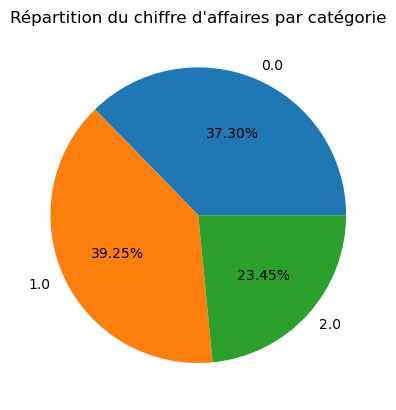

In [35]:
# Regroupement par catégorie.
CAParCateg = ventes.groupby('categ')['price'].sum()

# Reset de l'index.
CAParCateg = CAParCateg.reset_index()

plt.title("Répartition du chiffre d'affaires par catégorie")
plt.pie(x=CAParCateg['price'], labels=CAParCateg['categ'], autopct='%.2f%%')
plt.show()

La catégorie 1 de produit est la plus vendue avec 39,25 % du chiffre d'affaires suivi de la catégorie 0 avec 37,30 %.  
En dernier, c'est la catégorie 2 des produits qui ont été le moins vendus car elle représente 23,45 % du chiffre d'affaires.

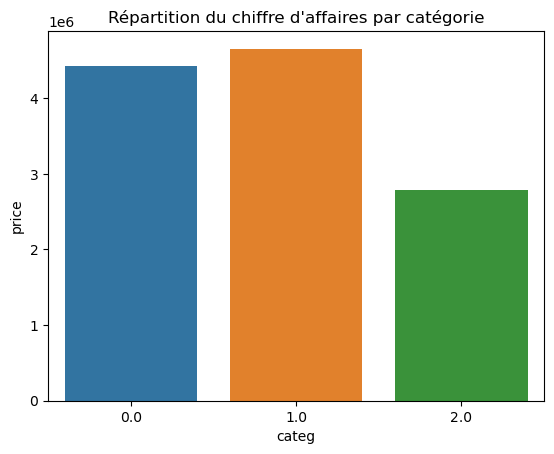

In [37]:
plt.title("Répartition du chiffre d'affaires par catégorie")
sns.barplot(data=ventes, x='categ', y='price', ci=None, estimator=sum)
plt.show()

On a bien les 2 catégories les plus représentées ainsi que la catégorie 2 qui fait le moins de ventes.

**Répartition du chiffre d'affaire par tranche d'âge** <a name="tranche_age"></a>

Pour pouvoir voir la répartition du chiffre d'affaires par tranche d'âge, on va rajouter une colonne "tranche d'âge" au dataframe.

In [10]:
ventes["tranche d'âge"] = '18 - 30'
ventes["tranche d'âge"].loc[(ventes['age'] > 30) & (ventes['age'] <= 40)] = '31 - 40'
ventes["tranche d'âge"].loc[(ventes['age'] > 40) & (ventes['age'] <= 50)] = '41 - 50'
ventes["tranche d'âge"].loc[(ventes['age'] > 50) & (ventes['age'] <= 60)] = '51 - 60'
ventes["tranche d'âge"].loc[(ventes['age'] > 60) & (ventes['age'] <= 70)] = '61 - 70'
ventes["tranche d'âge"].loc[(ventes['age'] > 70) & (ventes['age'] <= 80)] = '71 - 80'
ventes["tranche d'âge"].loc[ventes['age'] > 80] = '81 et +'

ventes

C:\Users\Greg\AppData\Local\Temp\ipykernel_14940\859407661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes["tranche d'âge"].loc[(ventes['age'] > 30) & (ventes['age'] <= 40)] = '31 - 40'
C:\Users\Greg\AppData\Local\Temp\ipykernel_14940\859407661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes["tranche d'âge"].loc[(ventes['age'] > 40) & (ventes['age'] <= 50)] = '41 - 50'
C:\Users\Greg\AppData\Local\Temp\ipykernel_14940\859407661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,client_id,sex,age,id_prod,date,session_id,price,categ,tranche d'âge
0,c_103,f,37,0_1518,2022-05-20 13:21:29.043970,s_211425,4.18,0.0,31 - 40
1,c_8534,m,35,1_251,2022-02-02 07:55:19.149409,s_158752,15.99,1.0,31 - 40
2,c_6714,f,55,0_1277,2022-06-18 15:44:33.155329,s_225667,7.99,0.0,51 - 60
3,c_6941,m,23,2_209,2021-06-24 04:19:29.835891,s_52962,69.99,2.0,18 - 30
4,c_4232,m,43,0_1509,2023-01-11 08:22:08.194479,s_325227,4.99,0.0,41 - 50
...,...,...,...,...,...,...,...,...,...
679527,c_8489,f,72,0_1551,2022-01-15 13:05:06.246925,s_150195,12.99,0.0,71 - 80
679528,c_4370,f,46,1_639,2022-03-19 16:03:23.429229,s_181434,10.99,1.0,41 - 50
679529,c_304,f,35,0_1425,2022-12-20 04:33:37.584749,s_314704,12.99,0.0,31 - 40
679530,c_2227,m,37,0_1994,2021-07-16 20:36:35.350579,s_63204,4.98,0.0,31 - 40


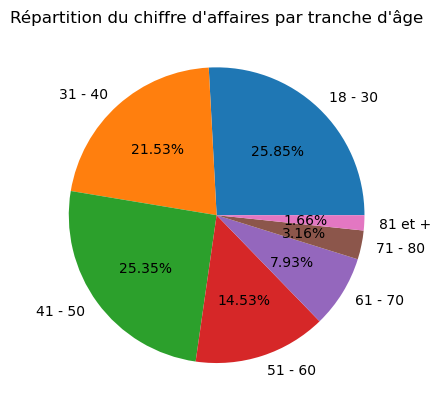

In [39]:
# Somme des prix par tranche d'âge.
CAParAge = ventes.groupby("tranche d'âge")['price'].sum()

# Reset de l'index.
CAParAge = CAParAge.reset_index()

plt.title("Répartition du chiffre d'affaires par tranche d'âge")
plt.pie(x=CAParAge['price'], labels=CAParAge["tranche d'âge"], autopct='%.2f%%')
plt.show()

Il y a 3 parts qui sont le plus représentée, La part des 18-30 avec 25,85 % suivi des 41-50 ans avec 25,35 % et en dernier, les 31-40 ans avec 21,53 %.  
Ceux qui sont le moins représentés sont les 81 et + avec une part de 1,66 %.  

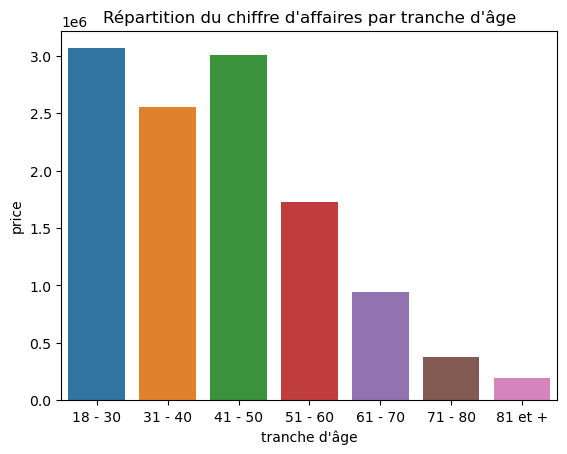

In [40]:
# Trie de la tranche d'âge 
ventes = ventes.sort_values("tranche d'âge")

plt.title("Répartition du chiffre d'affaires par tranche d'âge")
sns.barplot(data=ventes, x="tranche d'âge", y='price', ci=None, estimator=sum)
plt.show()

On retrouve les 3 parts les plus représenter. On remarque que plus on avance dans les tranches d'âge et plus le chiffre d'affaires diminue.

**Répartition du chiffre d'affaires par catégorie dans le temps** <a name="catégorie_temps"></a>

Pour pour visualiser ces informations, on va créer une colonne qui va contenir le mois avec l'année. 
On va ensuite grouper par les colonnes année-mois et la categ.

In [11]:
# Ajout de la colonne année-mois.
ventes['année-mois'] = pd.DatetimeIndex(ventes['date']).year.astype(str) + '-' + pd.DatetimeIndex(ventes['date']).month.astype(str)

# Convertion au format date.
ventes['année-mois'] = pd.to_datetime(ventes['année-mois'], format='%Y-%m')

ventes

,client_id,sex,age,id_prod,date,session_id,price,categ,tranche d'âge,année-mois
0,c_103,f,37,0_1518,2022-05-20 13:21:29.043970,s_211425,4.18,0.0,31 - 40,2022-05-01
1,c_8534,m,35,1_251,2022-02-02 07:55:19.149409,s_158752,15.99,1.0,31 - 40,2022-02-01
2,c_6714,f,55,0_1277,2022-06-18 15:44:33.155329,s_225667,7.99,0.0,51 - 60,2022-06-01
3,c_6941,m,23,2_209,2021-06-24 04:19:29.835891,s_52962,69.99,2.0,18 - 30,2021-06-01
4,c_4232,m,43,0_1509,2023-01-11 08:22:08.194479,s_325227,4.99,0.0,41 - 50,2023-01-01
...,...,...,...,...,...,...,...,...,...,...
679527,c_8489,f,72,0_1551,2022-01-15 13:05:06.246925,s_150195,12.99,0.0,71 - 80,2022-01-01
679528,c_4370,f,46,1_639,2022-03-19 16:03:23.429229,s_181434,10.99,1.0,41 - 50,2022-03-01
679529,c_304,f,35,0_1425,2022-12-20 04:33:37.584749,s_314704,12.99,0.0,31 - 40,2022-12-01
679530,c_2227,m,37,0_1994,2021-07-16 20:36:35.350579,s_63204,4.98,0.0,31 - 40,2021-07-01


In [42]:
# Regroupement par année-mois et categ en faisant la somme des prix.
CACategTemps = ventes.groupby(['année-mois', 'categ'])['price'].sum()

# Reset de l'index.
CACategTemps = CACategTemps.reset_index()

# Trie de la colonne année-mois.
CACategTemps = CACategTemps.sort_values(by='année-mois')

CACategTemps

,année-mois,categ,price
0,2021-03-01,0.0,193724.93
1,2021-03-01,1.0,186974.17
2,2021-03-01,2.0,101837.27
3,2021-04-01,0.0,205371.42
4,2021-04-01,1.0,156138.35
...,...,...,...
66,2023-01-01,0.0,181357.54
68,2023-01-01,2.0,126153.08
70,2023-02-01,1.0,180347.24
69,2023-02-01,0.0,162531.48


**Chiffre d'affaires Catégorie 0**

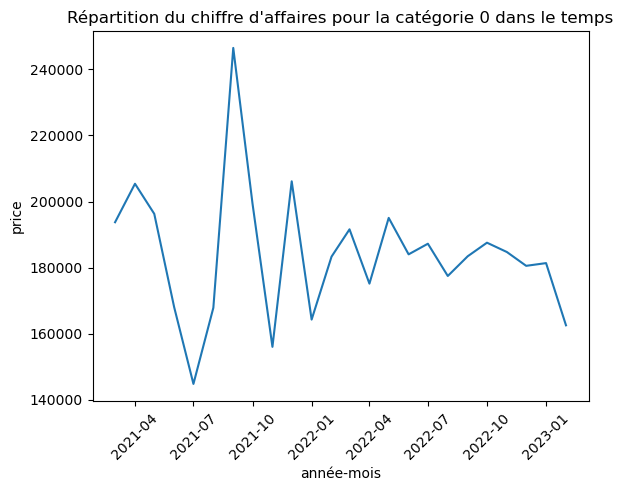

In [43]:
# Sélectionne la catégorie 0.
CACateg0Temps = CACategTemps.loc[CACategTemps['categ'] == 0, :]

plt.title("Répartition du chiffre d'affaires pour la catégorie 0 dans le temps")
plt.xticks(rotation=45)
sns.lineplot(data=CACateg0Temps, x='année-mois', y='price')
plt.show()

De manière globale, le chiffre d'affaires est entre 160 000 € et 210 000 € pendant cette période.  
Il a connu un pic en septembre 2021 avec environ 240 000 € du chiffre d'affaires.  
La période qui a le moins rapporté est en juillet 2021 avec environ 145 000 €.

**Chiffre d'affaires Catégorie 1**

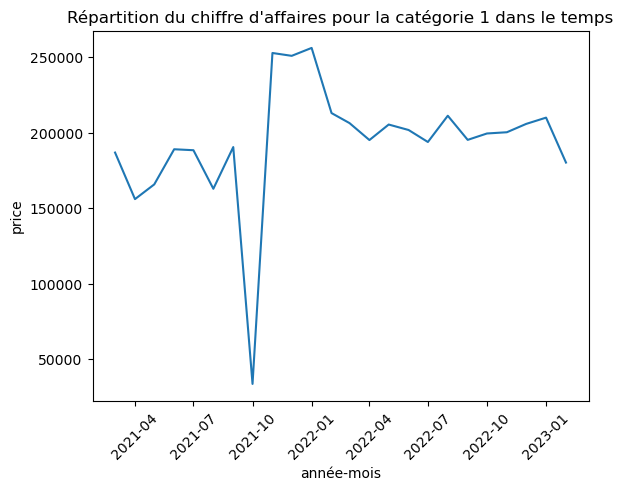

In [44]:
# Sélectionne la catégorie 1.
CACateg1Temps = CACategTemps.loc[CACategTemps['categ'] == 1, :]

plt.title("Répartition du chiffre d'affaires pour la catégorie 1 dans le temps")
plt.xticks(rotation=45)
sns.lineplot(data=CACateg1Temps, x='année-mois', y='price')
plt.show()

Les produits de la catégorie 1 ont généré le plus de chiffre d'affaires pour la période novembre et décembre 2021 avec 250 000 €.  
Globalement sur la période, le chiffre d'affaires est entre 150 000 € et 210 000 €.  
Il y a une anomalie pour le mois d'octobre, il n'y a pas d'information pour cette période.

**Chiffre d'affaires Catégorie 2**

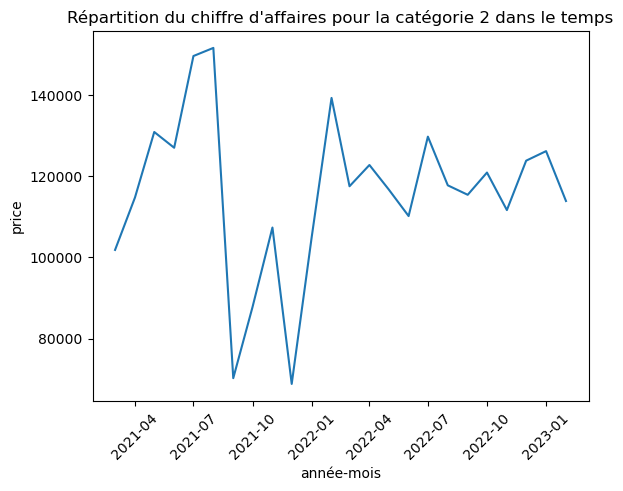

In [45]:
# Sélectionne la catégorie 2.
CACateg2Temps = CACategTemps.loc[CACategTemps['categ'] == 2, :]

plt.title("Répartition du chiffre d'affaires pour la catégorie 2 dans le temps")
plt.xticks(rotation=45)
sns.lineplot(data=CACateg2Temps, x='année-mois', y='price')
plt.show()

Pour la période, le chiffre d'affaires est entre 100 000 € et 140 000 €, il a 2 pics positifs et négatifs dans la courbe :
- En juillet/aout 2021 avec 150 000 € pour le positif.
- Une baisse à 70 000 € pour septembre et décembre 2021.

**Moyenne mobile** <a name="moyenne_mobile"></a>

Pour afficher la moyenne mobile, on va grouper sur les mois.  
On va travailler sur 2 moyennes mobiles, une de 3 mois et une autre de 5 mois.

In [46]:
# Regroupement de la colonne année-mois en faisant la somme des prix.
CAParDate = ventes.groupby('année-mois')['price'].sum()

# Reset de l'index.
CAParDate = CAParDate.reset_index()

# Trie de la colonne année-mois.
CAParDate = CAParDate.sort_values(by='année-mois')

# Met la colonne année-mois en index
CAParDate = CAParDate.set_index('année-mois')

CAParDate

,price
année-mois,
2021-03-01,482536.37
2021-04-01,476258.26
2021-05-01,493028.59
2021-06-01,484163.04
2021-07-01,482877.96
2021-08-01,482380.55
2021-09-01,507368.36
2021-10-01,320873.22
2021-11-01,516274.13


**Moyenne mobile sur 3 mois**

In [47]:
moyMobile3 = CAParDate['price'].to_frame()

# Calcul de la moyenne mobile sur 3 mois et création d'un colonne.
moyMobile3['mobile3Mois'] = moyMobile3['price'].rolling(3).mean()
 
# Supprime les valeurs nulles.
moyMobile3.dropna(inplace=True)

moyMobile3

,price,mobile3Mois
année-mois,,
2021-05-01,493028.59,483941.073333
2021-06-01,484163.04,484483.296667
2021-07-01,482877.96,486689.863333
2021-08-01,482380.55,483140.516667
2021-09-01,507368.36,490875.623333
2021-10-01,320873.22,436874.043333
2021-11-01,516274.13,448171.903333
2021-12-01,525991.76,454379.703333
2022-01-01,525392.19,522552.693333


Une fois qu'on a récupéré dans une colonne la moyenne mobile sur 3 mois, on va passer à la représentation graphique.

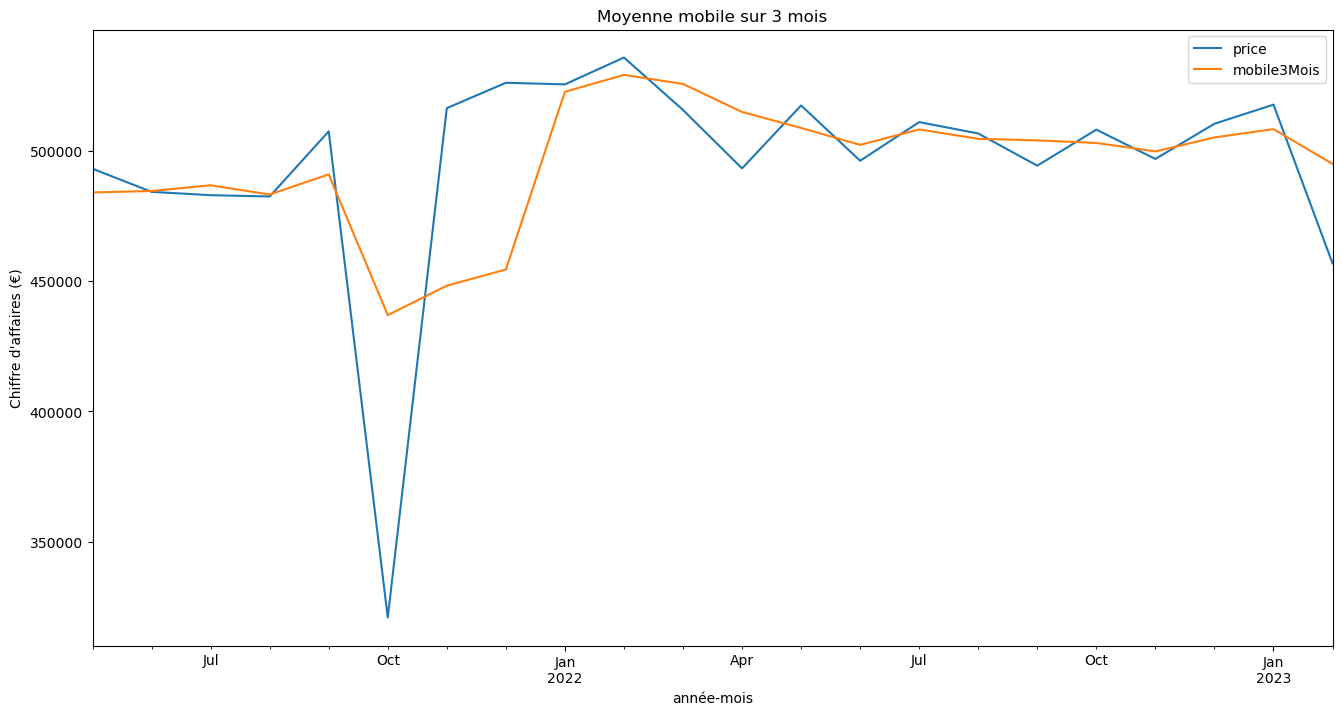

In [48]:
moyMobile3[['price', 'mobile3Mois']].plot(title = "Moyenne mobile sur 3 mois", ylabel = "Chiffre d'affaires (€)", label='RELIANCE', figsize=(16, 8))

plt.show()

**Moyenne mobile sur 5 mois**

In [49]:
moyMobile5 = CAParDate['price'].to_frame()

# Calcul de la moyenne mobile sur 5 mois et création d'une colonne.
moyMobile5['mobile5Mois'] = moyMobile5['price'].rolling(5).mean()

# Supprime les valeurs nulles.
moyMobile5.dropna(inplace=True)

moyMobile5

,price,mobile5Mois
année-mois,,
2021-07-01,482877.96,483772.844
2021-08-01,482380.55,483741.680
2021-09-01,507368.36,489963.700
2021-10-01,320873.22,455532.626
2021-11-01,516274.13,461954.844
2021-12-01,525991.76,470577.604
2022-01-01,525392.19,479179.932
2022-02-01,535688.54,484843.968
2022-03-01,515573.57,523784.038


Pareil que précédemment mais pour 5 mois.

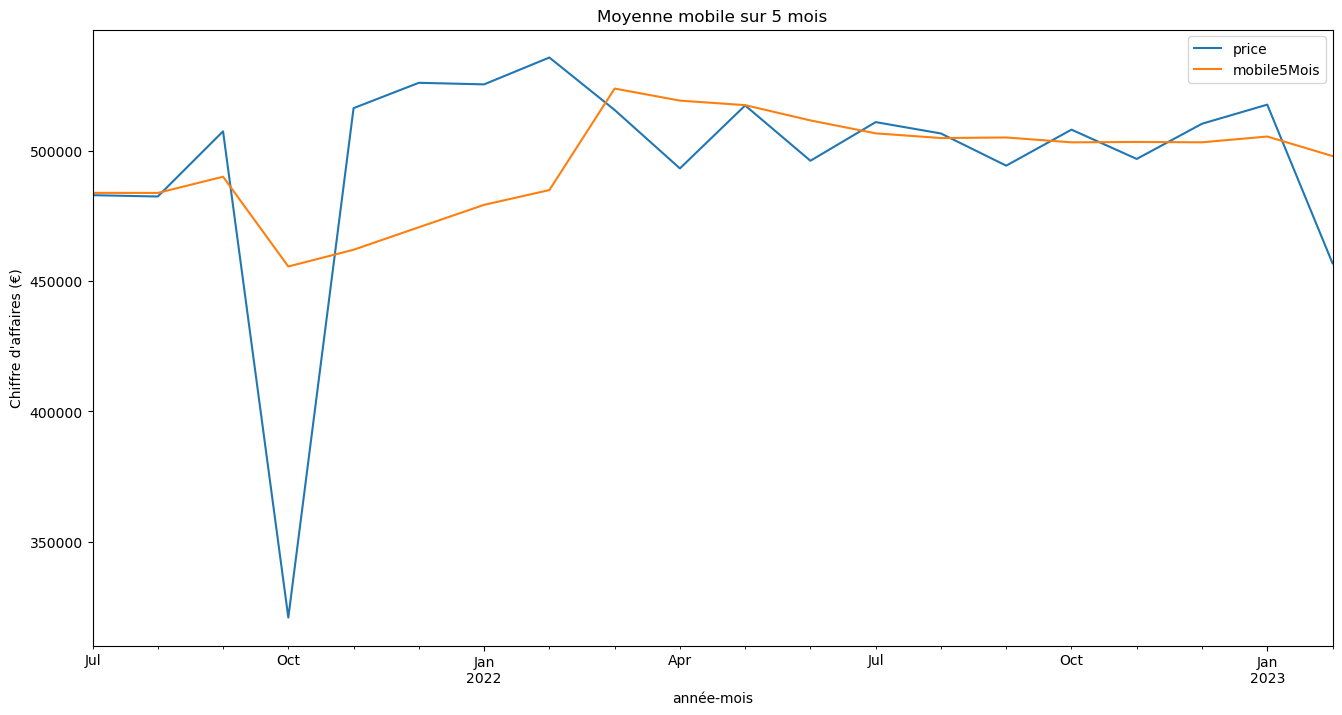

In [50]:
moyMobile5[['price', 'mobile5Mois']].plot(title = "Moyenne mobile sur 5 mois", ylabel = "Chiffre d'affaires (€)", label='RELIANCE', figsize=(16, 8))

plt.show()

On remarque que plus on prend une période grande, plus la courbe tend à se lisser.

### Zoom sur les références  <a name="référence"></a>

On va effectuer une analyse sur les références des produits pour voir ceux qui se vend le mieux et de même pour ceux qui se vend le moins bien.  
On va aussi voir la répartition par catégorie.  

**Meilleures et moins bonnes ventes** <a name="top_flop_global"></a>

**Meilleures ventes**

In [51]:
# Regroupement du nombre de vente par produit.
nombreVenteProduit= ventes.groupby(['id_prod', 'categ'])['id_prod'].size().reset_index(name='Nombre de vente')

# Trie par nombre de vente décroissant.
nombreVenteProduit = nombreVenteProduit.sort_values('Nombre de vente', ascending = False)

# Affiche les 10 premières ventes.
nombreVenteProduit.head(10)

,id_prod,categ,Nombre de vente
2592,1_369,1.0,2252
2645,1_417,1.0,2189
2642,1_414,1.0,2180
2734,1_498,1.0,2128
2654,1_425,1.0,2096
2630,1_403,1.0,1960
2640,1_412,1.0,1951
2641,1_413,1.0,1945
2633,1_406,1.0,1939
2634,1_407,1.0,1935


**Produits les moins biens vendus**

In [52]:
# Affiche les 10 dernières ventes.
nombreVenteProduit.tail(10)

,id_prod,categ,Nombre de vente
1327,0_2201,0.0,1
166,0_1151,0.0,1
802,0_1728,0.0,1
3248,2_81,2.0,1
595,0_1539,0.0,1
313,0_1284,0.0,1
1793,0_549,0.0,1
549,0_1498,0.0,1
1785,0_541,0.0,1
2167,0_886,0.0,1


**Meilleures et moins bonnes ventes par catégorie**  <a name="top_flop_catégorie"></a>

**Meilleurs ventes pour la catégorie 0**

In [53]:
# Sélection du nombre de vente pour la catégorie 0.
nbVenteCat0 = nombreVenteProduit.loc[nombreVenteProduit['categ'] == 0,:]

# Affiche les 10 premières ventes.
nbVenteCat0.head(10)

,id_prod,categ,Nombre de vente
466,0_1422,0.0,1292
476,0_1431,0.0,1282
469,0_1425,0.0,1266
477,0_1432,0.0,1254
454,0_1411,0.0,1246
472,0_1428,0.0,1245
0,0_0,0.0,1242
468,0_1424,0.0,1238
487,0_1441,0.0,1235
479,0_1434,0.0,1235


**Moins bonnes ventes pour la catégorie 0**

In [54]:
# Affiche les 10 dernières ventes.
nbVenteCat0.tail(10)

,id_prod,categ,Nombre de vente
2080,0_807,0.0,1
1327,0_2201,0.0,1
166,0_1151,0.0,1
802,0_1728,0.0,1
595,0_1539,0.0,1
313,0_1284,0.0,1
1793,0_549,0.0,1
549,0_1498,0.0,1
1785,0_541,0.0,1
2167,0_886,0.0,1


**Meilleurs ventes pour la catégorie 1**

In [55]:
# Sélection du nombre de vente pour la catégorie 1.
nbVenteCat1 = nombreVenteProduit.loc[nombreVenteProduit['categ'] == 1,:]

# Affiche les 10 premières ventes.
nbVenteCat1.head(10)

,id_prod,categ,Nombre de vente
2592,1_369,1.0,2252
2645,1_417,1.0,2189
2642,1_414,1.0,2180
2734,1_498,1.0,2128
2654,1_425,1.0,2096
2630,1_403,1.0,1960
2640,1_412,1.0,1951
2641,1_413,1.0,1945
2633,1_406,1.0,1939
2634,1_407,1.0,1935


**Moins bonnes ventes pour la catégorie 1**

In [58]:
# Affiche les 10 dernières ventes.
nbVenteCat1.tail(10)

,id_prod,categ,Nombre de vente
2313,1_117,1.0,4
2453,1_243,1.0,4
2432,1_224,1.0,4
2635,1_408,1.0,3
2631,1_404,1.0,3
2345,1_146,1.0,3
2636,1_409,1.0,3
2753,1_514,1.0,2
2649,1_420,1.0,2
2629,1_402,1.0,2


**Meilleurs ventes pour la catégorie 2**

In [59]:
# Sélection du nombre de vente pour la catégorie 2.
nbVenteCat2 = nombreVenteProduit.loc[nombreVenteProduit['categ'] == 2,:]

# Affiche les 10 premières ventes.
nbVenteCat2.head(10)

,id_prod,categ,Nombre de vente
3035,2_102,2.0,1027
3071,2_135,2.0,1005
3046,2_112,2.0,968
3202,2_39,2.0,915
3200,2_37,2.0,882
3044,2_110,2.0,865
3152,2_208,2.0,831
3153,2_209,2.0,814
3151,2_207,2.0,786
3042,2_109,2.0,744


**Moins bonnes ventes pour la catégorie 2**

In [60]:
# Affiche les 10 dernières ventes.
nbVenteCat2.tail(10)

,id_prod,categ,Nombre de vente
3232,2_66,2.0,3
3244,2_78,2.0,3
3190,2_28,2.0,3
3066,2_130,2.0,3
3067,2_131,2.0,3
3243,2_77,2.0,2
3259,2_93,2.0,2
3264,2_98,2.0,1
3176,2_23,2.0,1
3248,2_81,2.0,1


### Courbe de Lorenz  <a name="lorenz"></a>

On va récupérer des informations sur les profils des clients avec la répartition du chiffre d'affaires entre eux via une courbe de Lorenz et l'indice de Gini.

C:\Users\Greg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


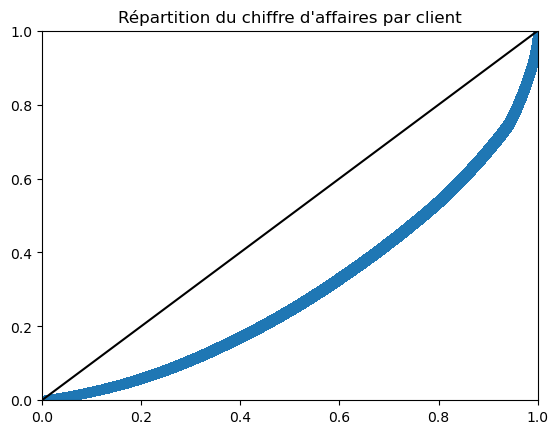

In [61]:
# Récupération des prix.
X = ventes['price'].values

# Tri des prix.
X = np.sort(X)

# Courbe de Lorenz.
X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)

sns.scatterplot(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, marker='x')

# Diagonale. 
plt.plot([0,1], [0,1], color='black')

plt.xlim([0,1])
plt.ylim([0,1])
plt.title("Répartition du chiffre d'affaires par client")
plt.show()

In [62]:
# Fonction indice de Gini.
def gini(array):
    sorted_array = array.copy()
    sorted_array.sort()
    n = array.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_array)])
    return coef_*weighted_sum/(sorted_array.sum()) - const_

print("L'indice de Gini est de", gini(X))

L'indice de Gini est de 0.39543859356337996


L'indice de Gini montre qu'il y a une inégalité du chiffre d'affaires entre les clients.

## Analyse de la clientèle <a name="analyse_client"></a>

**Genre d’un client et catégorie**

On va chercher s'il ya un lien entre le genre d’un client et les catégories des livres achetés.

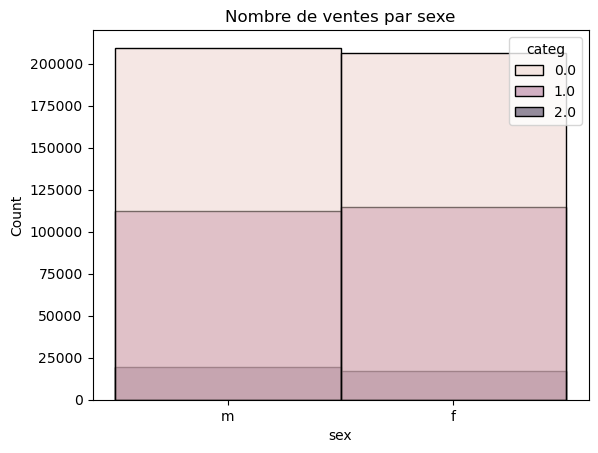

In [63]:
sns.histplot(data=ventes, x='sex', hue='categ')
plt.title('Nombre de ventes par sexe')
plt.show()

La répartition du nombre de ventes est égale entre les genres. On peut émettre comme hypothèse nulle que le sexe des clients n'a pas d'impact sur les catégories de livres achetés.

In [64]:
# Tableau de contingence.
contingence = pd.crosstab(ventes['categ'], ventes['sex'])

contingence

sex,f,m
categ,,
0.0,206220,209460
1.0,114899,112270
2.0,17283,19200


In [65]:
from scipy.stats import chi2_contingency as chi2_contingency

khi2, pval , ddl , contingent_theorique = chi2_contingency(contingence)

chi2_contingency(contingence)

(147.00253568681114,
 1.1989607410166063e-32,
 2,
 array([[207066.56444861, 208613.43555139],
        [113161.81769444, 114007.18230556],
        [ 18173.61785695,  18309.38214305]]))

On remarque que la p-value est faible, ce qui confirme notre hypothèse nulle entre le sexe des clients et la catégorie de livres achetés.

**Age des clients et le montant total des achats**

Pour voir le lien entre l'âge des clients et le montant total des achats, on va faire une régression linéaire. Pour cela, on va commencer par grouper les âges et faire la somme des prix.

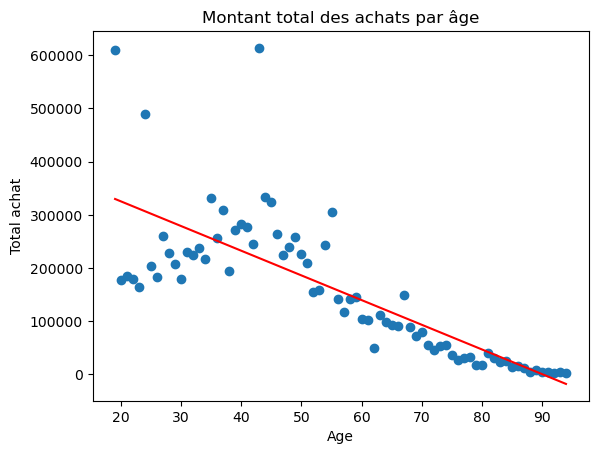

In [66]:
# Regroupement du total des price par âge.
totalAchatAge = ventes.groupby('age')['price'].sum()

# Reset de l'index.
totalAchatAge = totalAchatAge.reset_index()

# Renomme la colonne price en total achat.
totalAchatAge = totalAchatAge.rename(columns={'price': 'total achat'})

X = totalAchatAge['age']

Y = totalAchatAge['total achat'] 

plt.title("Montant total des achats par âge")
plt.xlabel("Age")
plt.ylabel("Total achat")
plt.scatter(X, Y)

# Création de la régression linéaire.
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

def predict(x):
   return slope * x + intercept

fitLine = predict(X)
plt.plot(X, fitLine, c='r')

plt.show()

On remarque que plus les clients sont âgés et plus le montant total des achats diminue.  

**Age des clients et la fréquence d’achat**

Pour voir le lien entre l'âges des clients et la fréquence des achats, on va le faire par régression linéaire.  
On commence par regrouper le total des ventes par clients pour ensuite connaitre les livres vendus par mois et on fait la moyenne des livres vendus par mois pour chaque âge.

In [67]:
# Regroupement du nombre de vente par client et ajout de la colonne total vente.
totalVenteClient = ventes.groupby(['client_id', 'age'])['id_prod'].size().reset_index(name='total vente')

# Ajout de la colonne vente par mois
totalVenteClient['vente par mois'] = totalVenteClient['total vente'] / ventes['année-mois'].nunique()

totalVenteClient

,client_id,age,total vente,vente par mois
0,c_1,68,39,1.625000
1,c_10,67,58,2.416667
2,c_100,31,8,0.333333
3,c_1000,57,125,5.208333
4,c_1001,41,102,4.250000
...,...,...,...,...
8595,c_995,68,14,0.583333
8596,c_996,53,95,3.958333
8597,c_997,29,59,2.458333
8598,c_998,22,53,2.208333


In [68]:
# Moyenne des ventes par mois pour chauqe âge.
frequenceAge = round(totalVenteClient.groupby('age')['vente par mois'].mean(),0)

# Reset de l'index.
frequenceAge = frequenceAge.reset_index()

frequenceAge

,age,vente par mois
0,19,1.0
1,20,1.0
2,21,1.0
3,22,1.0
4,23,1.0
...,...,...
71,90,2.0
72,91,2.0
73,92,2.0
74,93,2.0


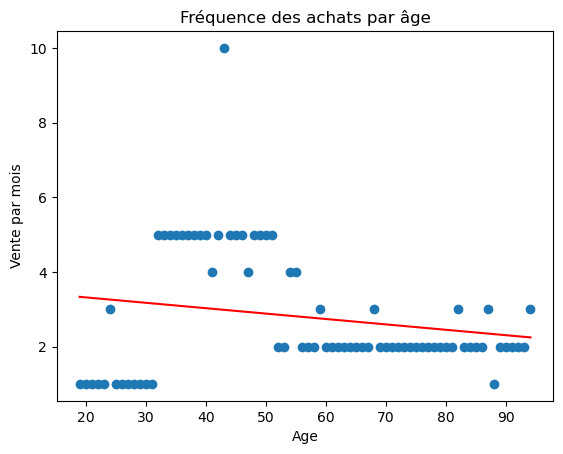

In [69]:
X = frequenceAge['age']

Y = frequenceAge['vente par mois'] 

plt.title("Fréquence des achats par âge")
plt.xlabel("Age")
plt.ylabel("Vente par mois")
plt.scatter(X, Y)

# Création de la régression linéaire.
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

def predict(x):
   return slope * x + intercept

fitLine = predict(X)
plt.plot(X, fitLine, c='r')

plt.show()

La courbe montre la fréquence d'achat doit être de 3 livres par mois pour n'importe quel âge.  
La majorité des clients achète 2 livres par mois en moyenne.  
La fréquence la plus importante est entre 32 - 51 ans avec 5 livres par mois.  
La fréquence la moins élevée est avec 1 livre par mois pour les 18 - 31 ans.

**Age des clients et la taille du panier moyen**

On va utiliser une régression linéaire pour voir le lien entre l'âge et le panier moyen.

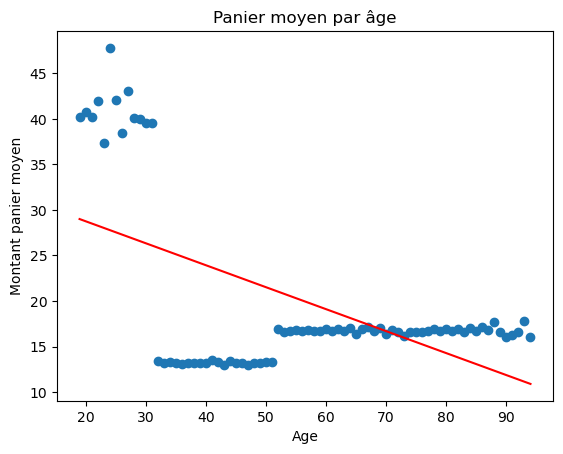

In [70]:
# Regroupement du total des prix par âge.
panierMoyen = ventes.groupby('age')['price'].mean()

# Reset de l'index.
panierMoyen = panierMoyen.reset_index()


# Renomme la colonne price en panier moyen.
panierMoyen = panierMoyen.rename(columns={'price': 'panier moyen'})

X = panierMoyen['age']

Y = panierMoyen['panier moyen'] 

plt.title("Panier moyen par âge")
plt.xlabel("Age")
plt.ylabel("Montant panier moyen")
plt.scatter(X, Y)

# Création de la régression linéaire.
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

def predict(x):
   return slope * x + intercept

fitLine = predict(X)
plt.plot(X, fitLine, c='r')

plt.show()

La régression linéaire commence à 30 € du panier moyen pour finir à environ 10 €.  
Le panier moyen le plus important est pour la tranche d'âge de 18 - 30 ans qui va avec un panier allant de 37 € à 47 €. 
Les 30 - 50 ans représente ceux où le panier moyen est le moins élevé avec une valeur de 15 €.

**Age des clients et les catégories de livres achetés**

Pour voir le lien entre l'âge des clients et les catégories de livres achetés, on va faire une analyse de la variance pour vérifier la corrélation entre une valeur qualitative et une valeur quantitative.  

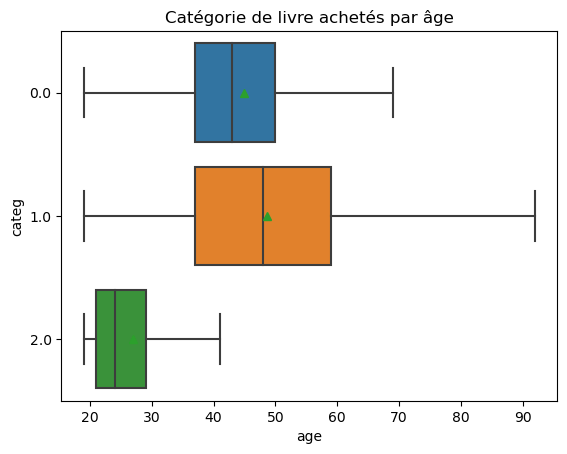

In [71]:
plt.title("Catégorie de livre achetés par âge")
plt.xlabel("Age")
plt.ylabel("Catégorie")

sns.boxplot(data=ventes, x='age', y='categ', orient='h', showfliers=False, showmeans=True)
plt.show()

Les triangles représentent l'âge moyen.  

On peut remarquer que des catégories de livre sont achetés que par certaines tranches d'âge.  
La catégorie 2 est achetée par les 18 - 40 ans avec une plus forte concentration entre les 20- 30 ans.
La catégorie 1 est achetée par tous les âges avec les 35 - 60 ans qui représentent 50 % des achats.
La catégorie 0 est achetée par une bonne partie des clients, l'âge va de 18 à 70 ans, avec une concentration de 35 à 50 ans. 

On va émettre comme hypothèse nulle qu'il y a lieu entre l'âge des clients et la catégorie de livre acheté.

On va afficher la moyenne des âges par catégorie.

In [14]:
# Moyenne des âges par catégorie.
ventes.groupby('categ').mean()['age']

categ
0.0    44.897616
1.0    48.651238
2.0    26.948031
Name: age, dtype: float64

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Test d'ANOVA.
sample_df = ventes.sample(5000)
model = smf.ols('age ~ categ', data=sample_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('ANOVA\np-value :', p, '\nstat (F) :', anova_table['F'][0])
if p > 0.05:
    print('H0: Les moyennes des échantillons sont égales.')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales.'
         '\n\nConditions :'
         '\n1. Normalité des résidus\n2. Homoscédasticité')

ANOVA
p-value : 1.9490296328669458e-11 
stat (F) : 45.22922390036153
H1: Une ou plusieurs des moyennes des échantillons sont inégales.

Conditions :
1. Normalité des résidus
2. Homoscédasticité


Il y a une inégalité entre les échantillons par rapport à leur moyenne.
On va faire un test de Shapiro pour voir la normalité des résidus.

Normalité des résidus (Shapiro)

stats : 0.9683151245117188 
p-value : 7.779171233445174e-32
H0 rejetée : distribution probablement pas normale.


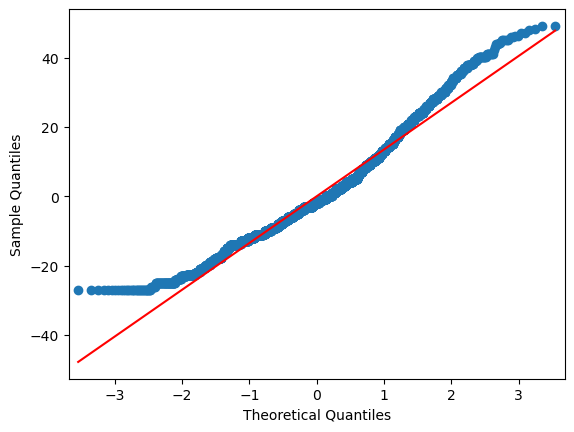

In [18]:
from statsmodels.graphics.gofplots import qqplot

# Test de Shapiro sur les résidus.
print('Normalité des résidus (Shapiro)')
print('\nstats :', stats.shapiro(model.resid)[0],
    '\np-value :', stats.shapiro(model.resid)[1])
if p>.05:
    print('H0 acceptée : distribution normale.')
else:
    print('H0 rejetée : distribution probablement pas normale.')
qqplot(model.resid, line='s')
plt.show()

La distribution des résidus n'est pas normale.  
On passe un test de Shapiro sur les résidus après boxcox.

Normalité des résidus après boxcox :
stats : nan 
p-value : 1.0
H0 acceptée : distribution normale.


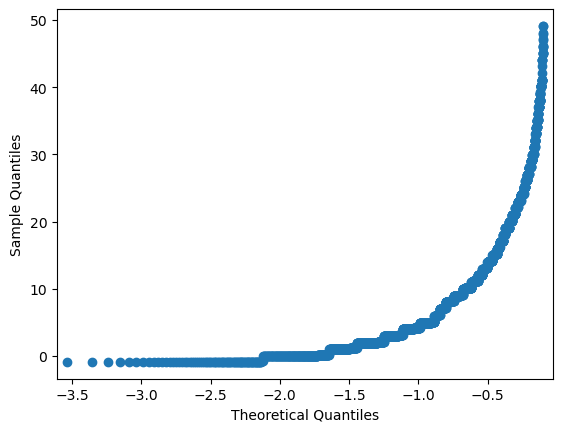

In [19]:
from scipy.special import boxcox1p

# Test de Shapiro sur les résidus après boxcox.
residus = boxcox1p(model.resid, 1)
p = stats.shapiro(residus)[1]
print('Normalité des résidus après boxcox :'
    '\nstats :', stats.shapiro(residus)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale.')
else:
    print('H0 rejetée : distribution probablement pas normale.')
qqplot(residus, line='s')
plt.show()

On voit qu'après un boxcox les résidus sont considérés comme normaux, la première condition de ANOVA est remplie.  
On va tester homoscédasticité des résidus pour voir si les variances sont égales. On va utiliser un test de Levene.

In [20]:
# Test de Levene sur les 3 catégories.
samples = 4000
a = ventes[ventes['categ']==0]['age'].sample(samples).values
b = ventes[ventes['categ']==1]['age'].sample(samples).values
c = ventes[ventes['categ']==2]['age'].sample(samples).values
stat, p = stats.levene(a, b, c)
print('Condition 2 : homoscédasticité (Levene)',
    '\nstats :', stat,
    '\np-value :', p)
if p > 0.05:
    print('H0: les variances sont égales.')
else:
    print('H1: les variances ne sont pas égales (essayer Welch ANOVA).')
print('\nConditions :'
      '\n- Les échantillons des populations considérées sont indépendants.',
      '\n- Les populations considérées sont à peu près normalement distribuées.')

Condition 2 : homoscédasticité (Levene) 
stats : 765.8575834907788 
p-value : 9.438639807e-314
H1: les variances ne sont pas égales (essayer Welch ANOVA).

Conditions :
- Les échantillons des populations considérées sont indépendants. 
- Les populations considérées sont à peu près normalement distribuées.


On remarque que le test de Levene n'est pas concluant.  
Si la condition d'homoscédasticité  n'est pas remplie, on utilise Welch ANOVA.

In [21]:
# Test de Welch entre catégorielle et quantitative
stat, p = stats.ttest_ind(sample_df['age'], sample_df['categ'])
print('Test de Welch (si absence d\'homoscédasticité)\n')
print('p-value :', p, '\nstat :', stat)
if p > 0.05:
    print('H0: les moyennes des échantillons sont égales')
else:
    print('H1: une ou plus des moyennes des échantillons sont inégales')

Test de Welch (si absence d'homoscédasticité)

p-value : 0.0 
stat : 232.72798271459044
H1: une ou plus des moyennes des échantillons sont inégales


On peut voir qu'il y a bien une corrélation entre l'âge et la catégorie.